# Monte Carlo Markov Chains para Galaxy Clustering

Agora que vimos os conceitos básicos de MCMC e análise estatística, é a sua vez. A Gabriela gerou dados observacionais da densidade de galáxias, enquanto o Guilherme explicou como fornecer previsões teóricas. O objetivo é obter intervalos de confiança para dois parâmetros cosmológicos, $\Omega_m$ e $\sigma_8$, e gerar um corner plot para ambos.

Vou deixar vocês com um código base, copiado da Gabriela e do Guilherme.

Me chamem se tiverem qualquer dúvida ou problema!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class

In [3]:
dv = np.load("data/cl_gg_input.npy")
ells = np.arange(2, len(dv) + 2)
zz, nz = np.load("data/dndz_input_z3_galaxy_field_lsstlike.npy")
np.savetxt("data/dndz_clustering_class.txt", np.stack((zz, nz), axis=1)) # Salvando no formato do CLASS

In [11]:
def get_cl_gg(Omega_m, sigma_8, bias=1.5):
    lmax = 2200
    params = {
        # Saídas necessárias (CMB + LSS)
        'modes': 's',
        'output': 'tCl, pCl, lCl, mPk, nCl, dCl',
        'lensing': 'yes',
        'l_max_scalars': lmax,
        'l_max_lss': lmax,
        'number_count_contributions': 'density',

        # Energia escura via fld
        'Omega_Lambda': 0,
        'w0_fld': '-1.',
        'wa_fld': '0.0',

        # Espectro primordial (n_s fixo; sigma8 varia no loop)
        'n_s': 0.96,

        # Fundo
        'h': 0.673,
        'Omega_b': 0.03,

        # Verbosidade e gauge
        'background_verbose': 0,
        'perturbations_verbose': 0,
        'gauge': 'Synchronous',

        # P(k)
        'z_pk': '5.0, 0.0',
        'P_k_max_h/Mpc': 10,
        'k_per_decade_for_pk': 30,
        'dNdz_selection': 'data/dndz_class.txt',
    }
    Omega_nu_fid = 0.06/93.15/params['h']**2
    params.update({
        'Omega_cdm': Omega_m - params['Omega_b'] - Omega_nu_fid,
        'sigma8': sigma_8,
    })
    
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    
    cl_dens = cosmo.density_cl(lmax)
    Cl_gg = bias**2 * cl_dens['dd']['dens[1]-dens[1]']
    ell = np.arange(len(Cl_gg))
    return ell, np.asarray(Cl_gg)

In [12]:
# Dados Gabi
data_cl_gg = np.array([1.78142794e-05, 2.08104093e-05, 1.86347323e-05, 1.78612158e-05,
       1.06061664e-05, 1.14404840e-05, 9.32404084e-06, 8.26436501e-06,
       7.04118780e-06, 6.40005133e-06, 5.77462498e-06, 5.50909229e-06,
       4.98857085e-06, 4.39896033e-06, 4.13286971e-06, 3.60756474e-06,
       2.98927245e-06, 2.25474238e-06, 1.44657207e-06, 7.39427158e-07])
data_ells = np.array([  33.71251652,   42.05640149,   52.46540717,   65.45065323,
         81.64976198,  101.858168  ,  127.06817675,  158.51769044,
        197.7509934 ,  246.69458206,  307.7517628 ,  383.92066303,
        478.94144994,  597.47998627,  745.35694088,  929.83360462,
       1159.96844581, 1447.06191363, 1805.21133092, 2252.00312343])
n_gal = 222828.6428782517

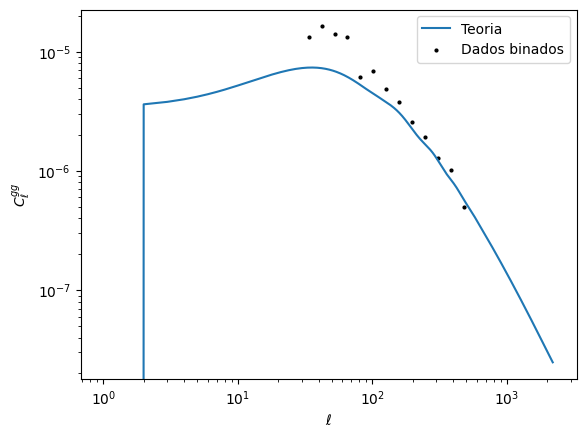

In [13]:
# Exemplo de cosmologia
ell, cl_gg = get_cl_gg(Omega_m=0.3, sigma_8=0.820)
plt.loglog(ell, cl_gg, label="Teoria")
plt.scatter(data_ells, data_cl_gg - 1/n_gal, label="Dados binados", s=4, color="black")
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell^{gg}$")
plt.legend()
plt.savefig("comparacao_cl_gg_pontos.pdf")